In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False

import os

# File path
PATH = r"C:\Users\Acer\Downloads\anoly\2\archive (4)\fraudTest.csv"

# Extract directory path
directory_path = os.path.dirname(PATH)

# Print the list of files in the directory
print(os.listdir(directory_path))


['Book1.csv', 'fraudTest.csv', 'fraudTrain.csv']


In [2]:
import pandas as pd

# File path
PATH = r"C:\Users\Acer\Downloads\anoly\2\archive (4)\fraudTest.csv"

# Read the CSV file
data_df = pd.read_csv(PATH)

# Display the DataFrame
print(data_df)


        Unnamed: 0 trans_date_trans_time            cc_num  \
0                0   2020-06-21 12:14:25  2291163933867244   
1                1   2020-06-21 12:14:33  3573030041201292   
2                2   2020-06-21 12:14:53  3598215285024754   
3                3   2020-06-21 12:15:15  3591919803438423   
4                4   2020-06-21 12:15:17  3526826139003047   
...            ...                   ...               ...   
555714      555714   2020-12-31 23:59:07    30560609640617   
555715      555715   2020-12-31 23:59:09  3556613125071656   
555716      555716   2020-12-31 23:59:15  6011724471098086   
555717      555717   2020-12-31 23:59:24     4079773899158   
555718      555718   2020-12-31 23:59:34  4170689372027579   

                                    merchant        category     amt    first  \
0                      fraud_Kirlin and Sons   personal_care    2.86     Jeff   
1                       fraud_Sporer-Keebler   personal_care   29.84   Joanne   
2       frau

In [4]:
print("Credit Card Fraud Detection data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])

Credit Card Fraud Detection data -  rows: 555719  columns: 23


In [5]:
data_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [6]:
print(data_df.columns)


Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')


In [7]:
def flatten_list(nested_list):
    return [item for sublist in nested_list for item in sublist]


In [9]:
hist_data = [flatten_list('is_fraud'), flatten_list('trans_date_trans_time')]


In [10]:
data_df.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,555719.000000,5.557190e+05,555719.000000,555719.000000,555719.000000,555719.000000,5.557190e+05,5.557190e+05,555719.000000,555719.000000,555719.000000
mean,277859.000000,4.178387e+17,69.392810,48842.628015,38.543253,-90.231325,8.822189e+04,1.380679e+09,38.542798,-90.231380,0.003860
std,160422.401459,1.309837e+18,156.745941,26855.283328,5.061336,13.721780,3.003909e+05,5.201104e+06,5.095829,13.733071,0.062008
min,0.000000,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1.371817e+09,19.027422,-166.671575,0.000000
25%,138929.500000,1.800429e+14,9.630000,26292.000000,34.668900,-96.798000,7.410000e+02,1.376029e+09,34.755302,-96.905129,0.000000
50%,277859.000000,3.521417e+15,47.290000,48174.000000,39.371600,-87.476900,2.408000e+03,1.380762e+09,39.376593,-87.445204,0.000000
75%,416788.500000,4.635331e+15,83.010000,72011.000000,41.894800,-80.175200,1.968500e+04,1.385867e+09,41.954163,-80.264637,0.000000
max,555718.000000,4.992346e+18,22768.110000,99921.000000,65.689900,-67.950300,2.906700e+06,1.388534e+09,66.679297,-66.952026,1.000000


In [11]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Unnamed: 0,zip,merch_long,merch_lat,unix_time,trans_num,dob,job,city_pop,long,lat,state,trans_date_trans_time,city,street,gender,last,first,amt,category,merchant,cc_num,is_fraud
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
temp = data_df['is_fraud'].value_counts()
df = pd.DataFrame({'is_fraud': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['is_fraud'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'is_fraud', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='is_fraud')

In [17]:
import pandas as pd
data_df = pd.read_csv(r"C:\Users\Acer\Downloads\anoly\2\archive (4)\fraudTrain.csv")


In [22]:
# Assuming your DataFrame is already loaded and 'trans_date_trans_time' has been converted to datetime
import pandas as pd
import plotly.figure_factory as ff
from plotly.offline import iplot

# Convert 'trans_date_trans_time' to datetime
data_df['trans_date_trans_time'] = pd.to_datetime(data_df['trans_date_trans_time'])

# Convert datetime to 'int64' to get Unix timestamp (in nanoseconds) and then convert to seconds
data_df['trans_time_numeric'] = data_df['trans_date_trans_time'].astype('int64') // 10**9

# Now, use 'trans_time_numeric' for your plots
class_0 = data_df.loc[data_df['is_fraud'] == 0]['trans_time_numeric']
class_1 = data_df.loc[data_df['is_fraud'] == 1]['trans_time_numeric']

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='trans_date_trans_time [s]'))
iplot(fig, filename='dist_only')


In [23]:
import pandas as pd
import numpy as np

# Assuming data_df is your DataFrame and 'trans_date_trans_time' is in datetime format.
# If 'trans_date_trans_time' is not in datetime format, convert it:
data_df['trans_date_trans_time'] = pd.to_datetime(data_df['trans_date_trans_time'])

# Extract the hour from 'trans_date_trans_time'
data_df['Hour'] = data_df['trans_date_trans_time'].dt.hour

# Replace 'Class' with 'is_fraud' and 'Amount' with 'amt' according to your dataset
tmp = data_df.groupby(['Hour', 'is_fraud'])['amt'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()

# Convert the aggregated result to a DataFrame and rename the columns appropriately
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']

# Display the first few rows of the dataframe
df.head()


,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0,0,1.00,7747.73,41867,3145659.21,75.134574,61.130,10150.876746
1,0,1,6.02,1257.80,635,218345.21,343.850724,300.000,94577.297001
2,1,0,1.00,4169.50,42211,3183360.73,75.415430,61.650,9075.549142
3,1,1,5.93,1289.89,658,230736.79,350.663815,306.295,96407.406446
4,2,0,1.00,2459.24,42031,3192034.07,75.944757,62.090,8739.654040


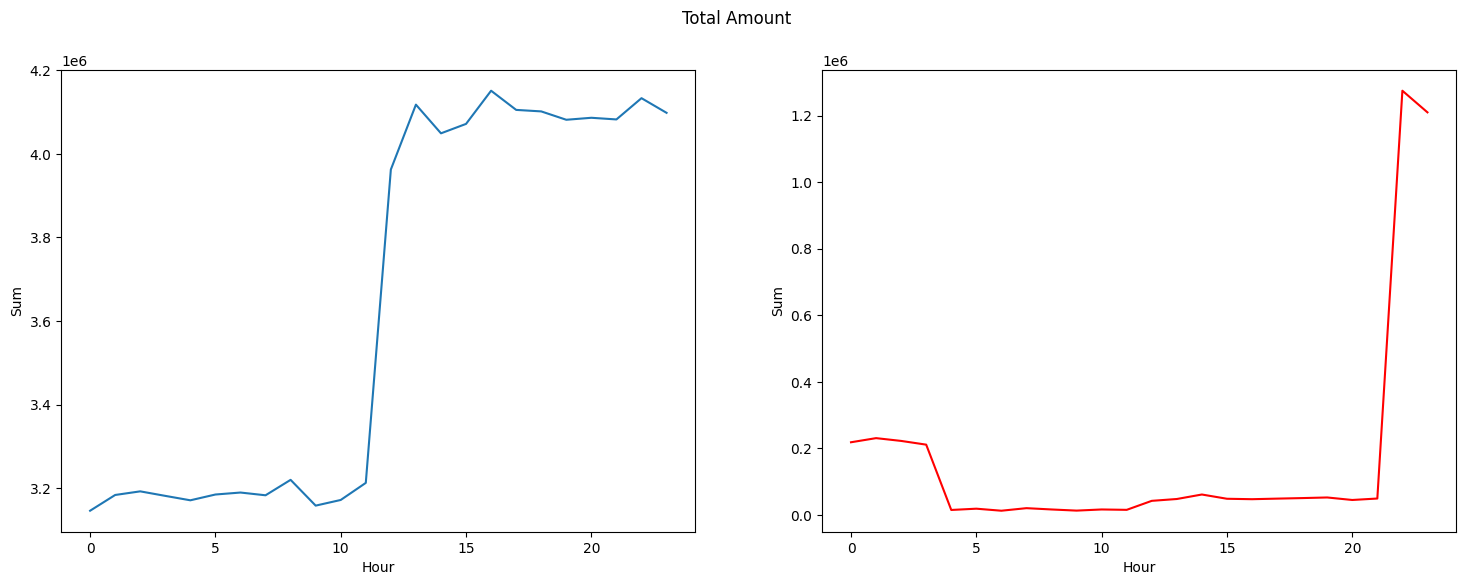

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show();

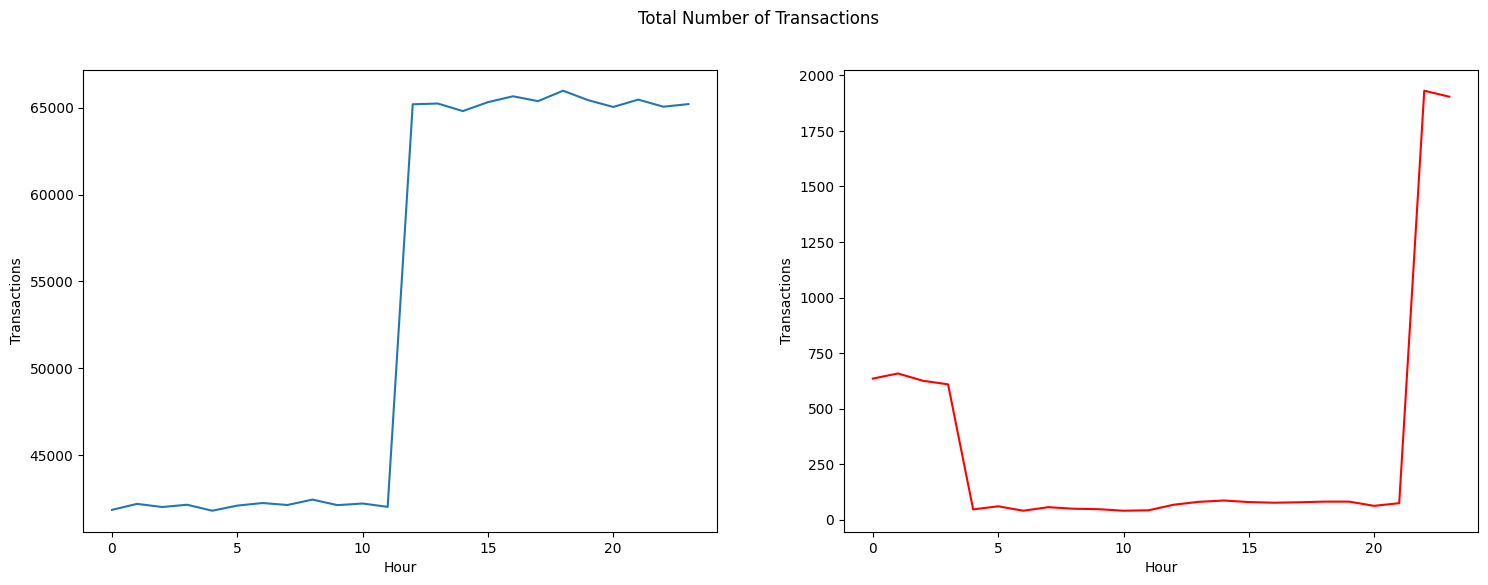

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Number of Transactions")
plt.show();

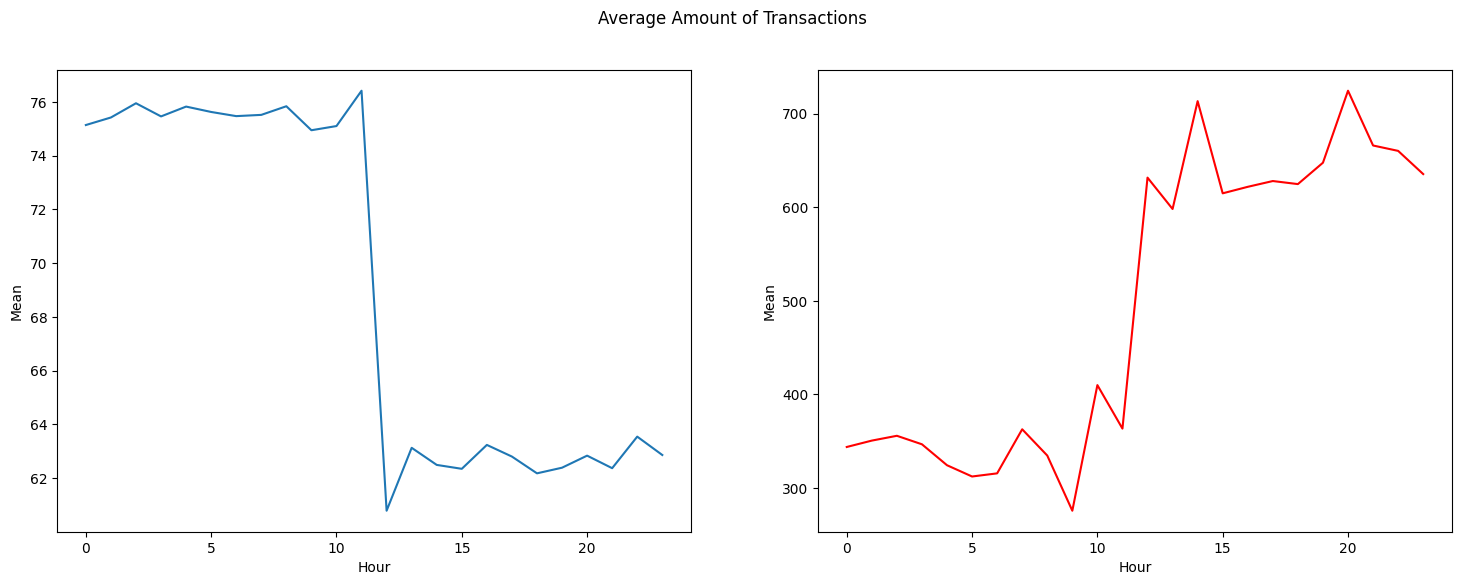

In [26]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Average Amount of Transactions")
plt.show();

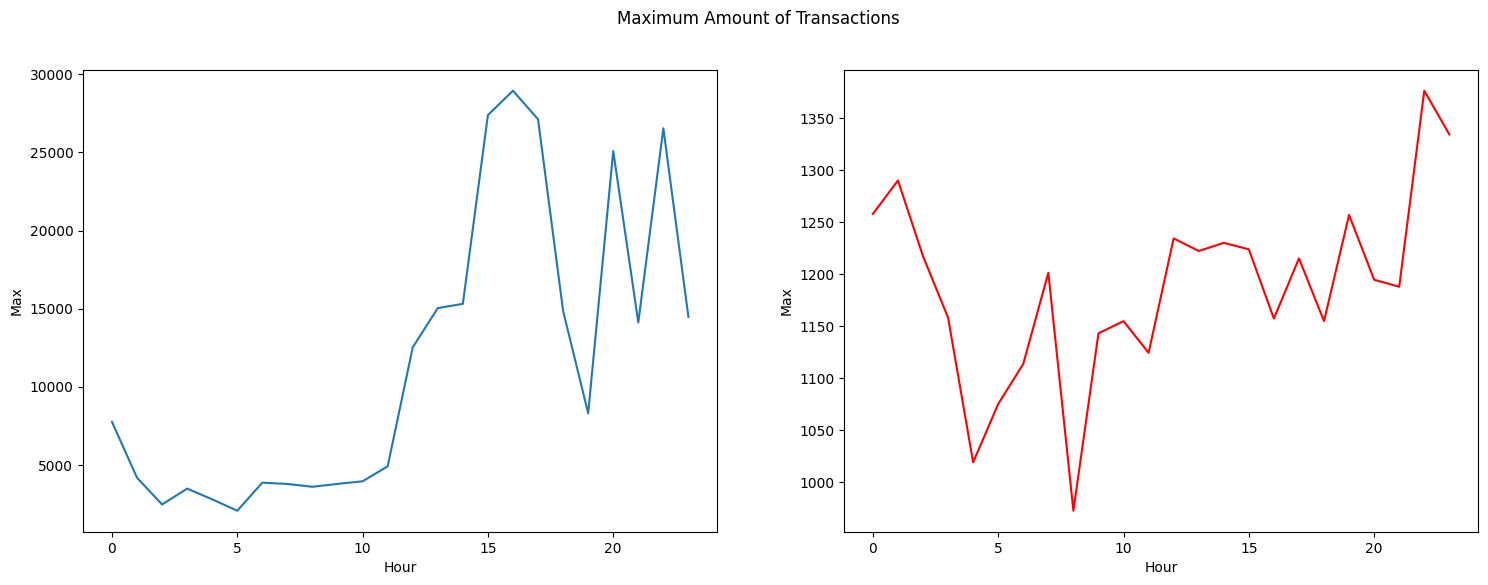

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show();

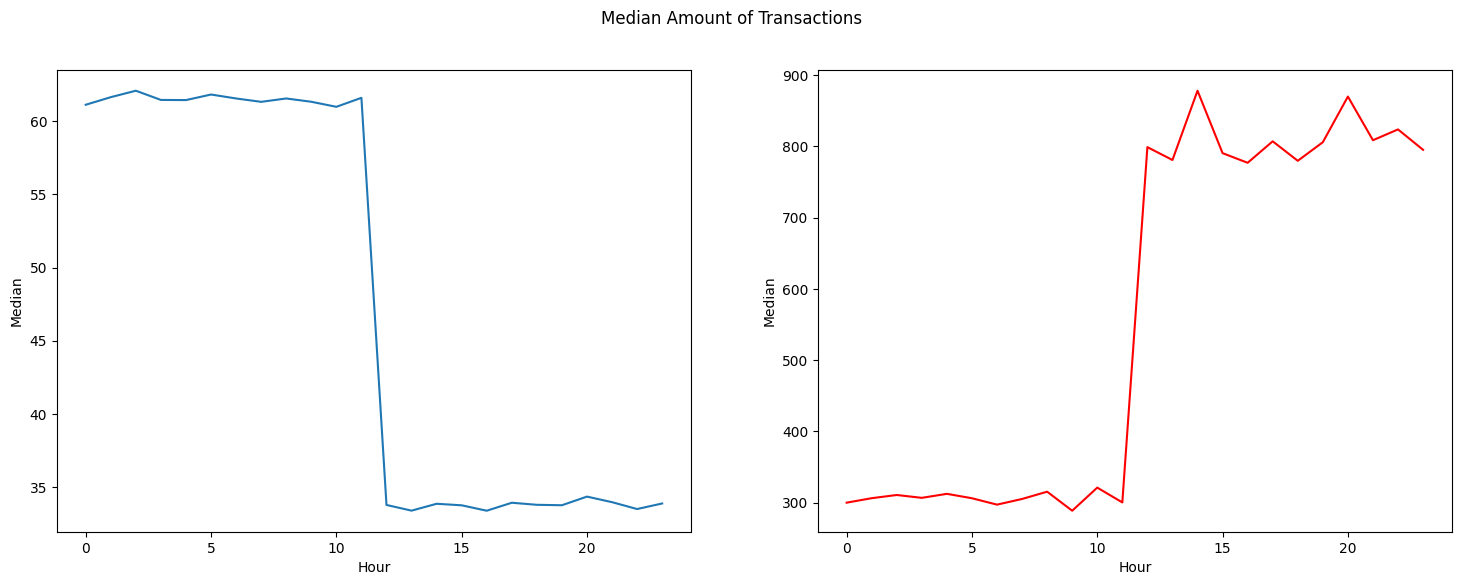

In [28]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=df.loc[df.Class==1], color="red")
plt.suptitle("Median Amount of Transactions")
plt.show();

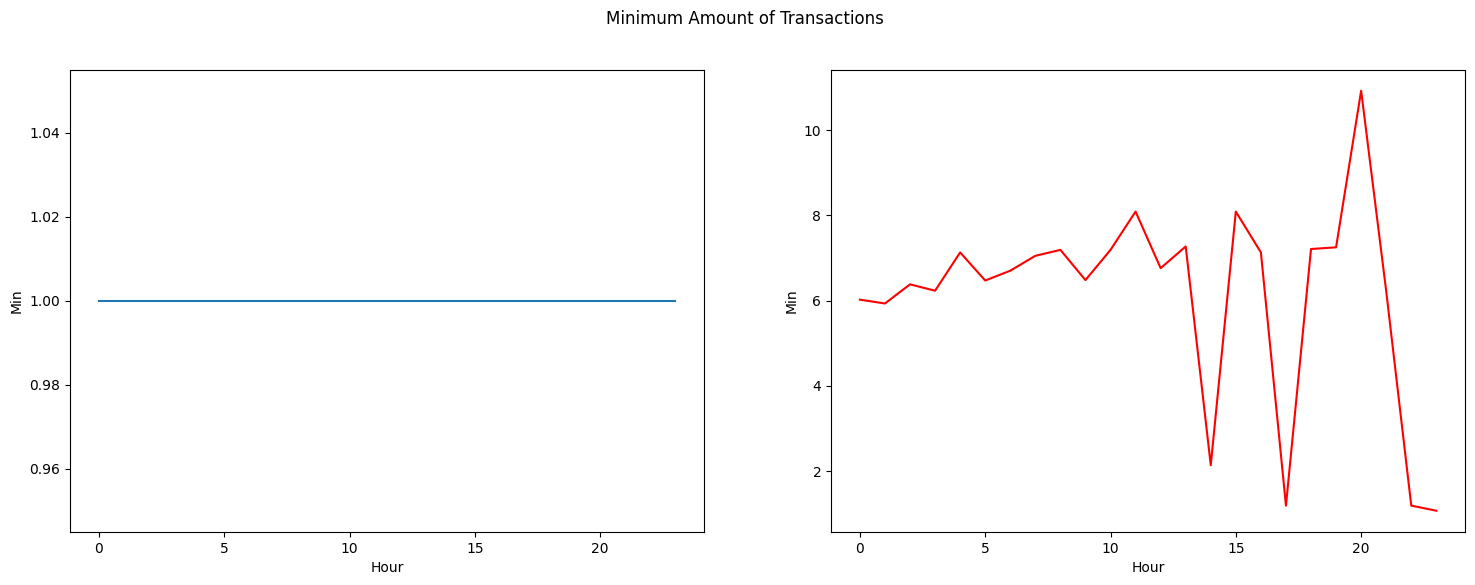

In [29]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red")
plt.suptitle("Minimum Amount of Transactions")
plt.show();

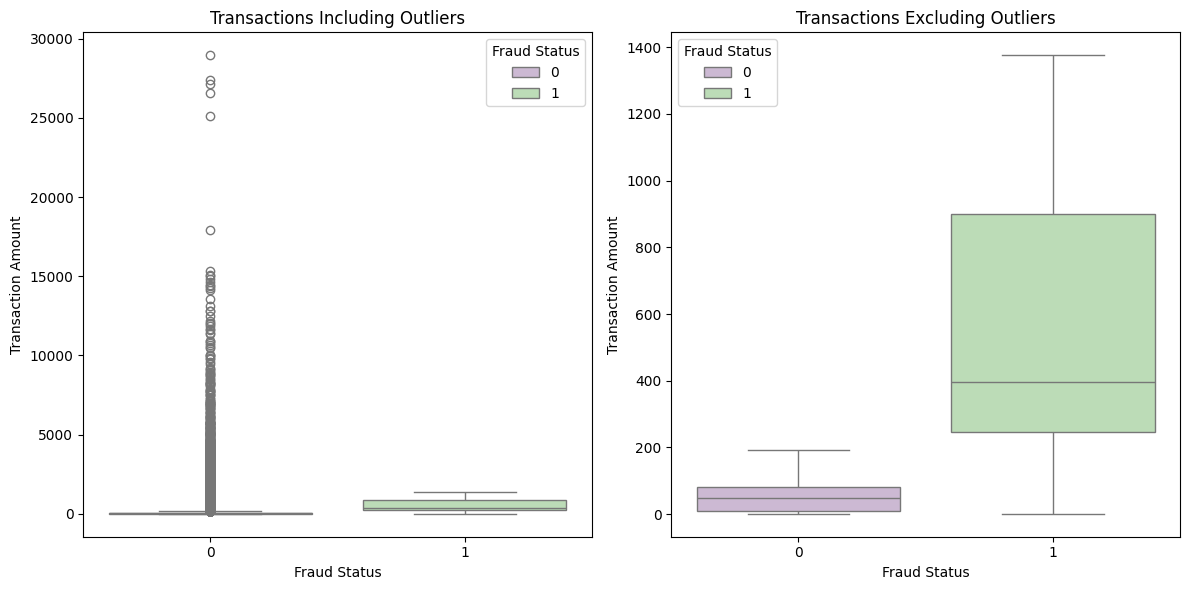

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure with two subplots (axes)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# Create a boxplot on the first axis (ax1) showing outliers (showfliers=True)
s1 = sns.boxplot(ax=ax1, x="is_fraud", y="amt", hue="is_fraud", data=data_df, palette="PRGn", showfliers=True)
ax1.set_title('Transactions Including Outliers')  # Optionally, add a title to ax1
# Set custom labels if you want to change them
ax1.set_xlabel('Fraud Status')
ax1.set_ylabel('Transaction Amount')
ax1.legend(title='Fraud Status')

# Create a boxplot on the second axis (ax2) without showing outliers (showfliers=False)
s2 = sns.boxplot(ax=ax2, x="is_fraud", y="amt", hue="is_fraud", data=data_df, palette="PRGn", showfliers=False)
ax2.set_title('Transactions Excluding Outliers')  # Optionally, add a title to ax2
# Set custom labels if you want to change them
ax2.set_xlabel('Fraud Status')
ax2.set_ylabel('Transaction Amount')
ax2.legend(title='Fraud Status')

# Display the plots
plt.tight_layout()  # Adjust the layout to make room for the titles and axis labels
plt.show();


In [31]:
# Create a temporary copy of the data with the relevant columns, using the correct column names
tmp = data_df[['amt', 'is_fraud']].copy()

# Select the amounts for transactions classified as non-fraudulent (class 0)
class_0 = tmp.loc[tmp['is_fraud'] == 0]['amt']

# Use .describe() to get a summary of statistics for non-fraudulent transaction amounts
class_0_description = class_0.describe()

# Display the summary statistics
class_0_description

count    1.289169e+06
mean     6.766711e+01
std      1.540080e+02
min      1.000000e+00
25%      9.610000e+00
50%      4.728000e+01
75%      8.254000e+01
max      2.894890e+04
Name: amt, dtype: float64

In [32]:
class_1.describe()

count    7.506000e+03
mean     1.569258e+09
std      1.383848e+07
min      1.546391e+09
25%      1.556582e+09
50%      1.569711e+09
75%      1.580860e+09
max      1.592712e+09
Name: trans_time_numeric, dtype: float64

In [33]:
import plotly.graph_objs as go
from plotly.offline import iplot

# Assuming 'Class', 'Time', and 'Amount' are correct column names in your DataFrame
# Selecting rows where transactions are fraudulent
fraud = data_df.loc[data_df['is_fraud'] == 1]

# Creating a Scatter plot trace
trace = go.Scatter(
    x=fraud['trans_date_trans_time'], y=fraud['amt'],
    name='amt',
    marker=dict(
        color='rgb(238,23,11)',
        line=dict(
            color='red',
            width=1
        ),
        opacity=0.5
    ),
    text=fraud['amt'],
    mode="markers"
)

# Defining the layout of the plot
layout = go.Layout(
    title='Amount of Fraudulent Transactions',
    xaxis=dict(title='trans_date_trans_time [s]', showticklabels=True),
    yaxis=dict(title='amt'),
    hovermode='closest'
)

# Creating a figure with the data and layout
fig = go.Figure(data=[trace], layout=layout)

# Displaying the plot
iplot(fig, filename='fraud-amount')


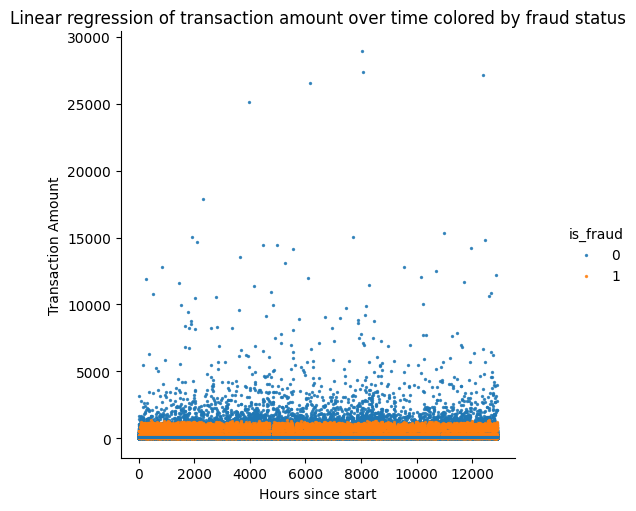

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'trans_date_trans_time' to a numerical format: hours since the start of the dataset
data_df['hours_since_start'] = (data_df['trans_date_trans_time'] - data_df['trans_date_trans_time'].min()) / pd.Timedelta(hours=1)

# Now, use 'hours_since_start' as the x-axis for your lmplot
s = sns.lmplot(x='hours_since_start', y='amt', data=data_df, hue='is_fraud', fit_reg=True, scatter_kws={'s': 2})
plt.title('Linear regression of transaction amount over time colored by fraud status')
plt.xlabel('Hours since start')
plt.ylabel('Transaction Amount')
plt.show()


<Figure size 1600x2800 with 0 Axes>

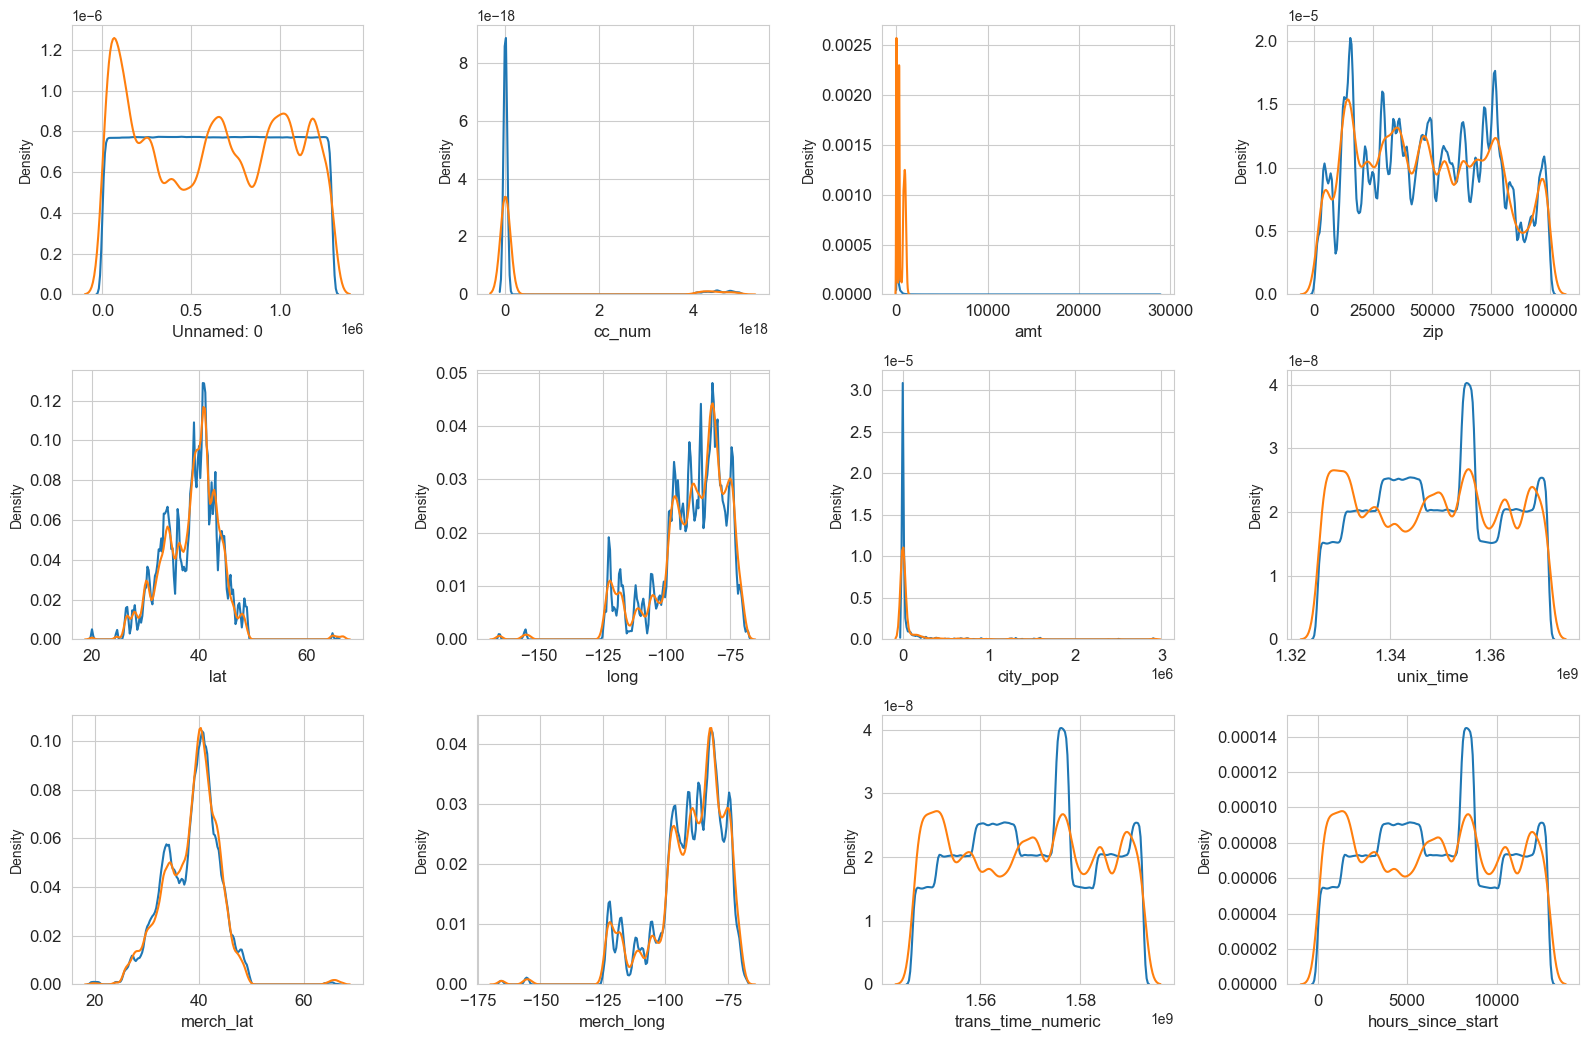

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Updating column selection to exclude non-numeric columns and 'is_fraud'
numeric_cols = data_df.select_dtypes(include=['float64', 'int64']).columns.drop('is_fraud')

# Splitting the dataset based on 'is_fraud' status
t0 = data_df.loc[data_df['is_fraud'] == 0]
t1 = data_df.loc[data_df['is_fraud'] == 1]

sns.set_style('whitegrid')
plt.figure(figsize=(16,28))

# Calculate the number of rows needed for subplots
n_rows = len(numeric_cols) // 4 + (len(numeric_cols) % 4 > 0)

fig, ax = plt.subplots(n_rows, 4, figsize=(16, n_rows*3.5))

for i, feature in enumerate(numeric_cols):
    row = i // 4
    col = i % 4
    sns.kdeplot(t0[feature], bw_adjust=0.5, ax=ax[row, col], label="Class = 0")
    sns.kdeplot(t1[feature], bw_adjust=0.5, ax=ax[row, col], label="Class = 1")
    ax[row, col].set_xlabel(feature, fontsize=12)
    ax[row, col].tick_params(axis='both', which='major', labelsize=12)

# Hide any unused subplot areas (if the number of features is not divisible by 4)
for j in range(i + 1, n_rows * 4):
    fig.delaxes(ax.flatten()[j])

fig.tight_layout()
plt.show()


In [36]:
# Corrected target column name
target = 'is_fraud'

# Example predictor columns based on your dataset description
# Note: Replace these with actual numeric columns you wish to use for prediction
predictors = ['amt', 'unix_time', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']


In [37]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [38]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [39]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

In [40]:
preds = clf.predict(valid_df[predictors])

C:\Users\Acer\AppData\Local\Temp\ipykernel_10196\499894721.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



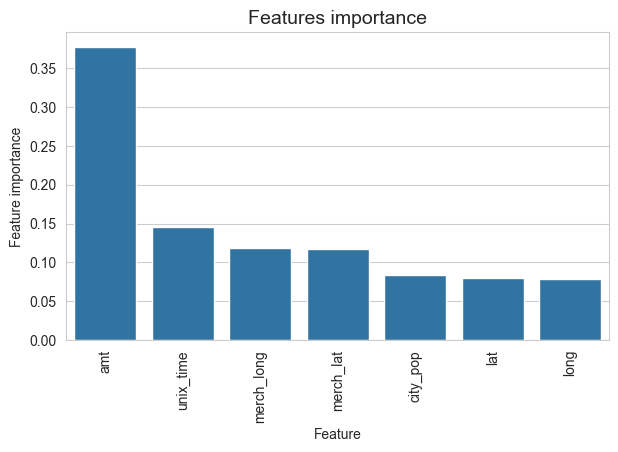

In [41]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   


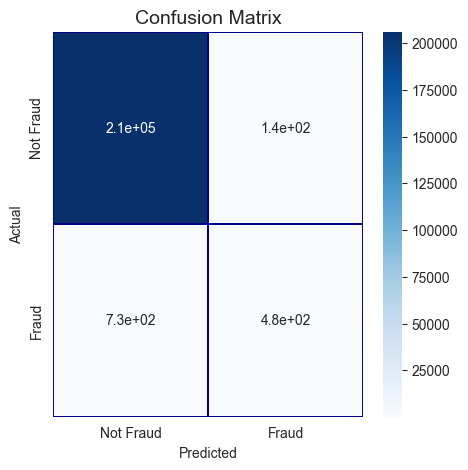

In [42]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [43]:
roc_auc_score(valid_df[target].values, preds)

0.6980129968621819

In [44]:
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

In [45]:
clf.fit(train_df[predictors], train_df[target].values)

C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2018)

In [46]:
preds = clf.predict(valid_df[predictors])

C:\Users\Acer\AppData\Local\Temp\ipykernel_10196\1035525770.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



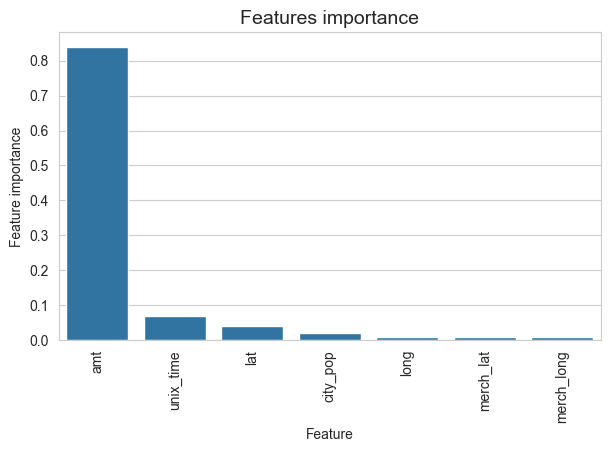

In [47]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

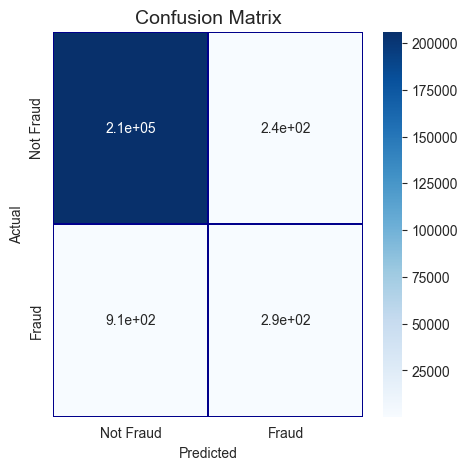

In [48]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [49]:
roc_auc_score(valid_df[target].values, preds)

0.6210071024216897

In [50]:
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [51]:
clf.fit(train_df[predictors], train_df[target].values,verbose=True)

0:	total: 471ms	remaining: 3m 55s
50:	total: 12.4s	remaining: 1m 49s
100:	total: 23.8s	remaining: 1m 34s
150:	total: 35.3s	remaining: 1m 21s
200:	total: 46.9s	remaining: 1m 9s
250:	total: 58.3s	remaining: 57.8s
300:	total: 1m 9s	remaining: 46.2s
350:	total: 1m 21s	remaining: 34.5s
400:	total: 1m 32s	remaining: 22.8s
450:	total: 1m 43s	remaining: 11.3s
499:	total: 1m 55s	remaining: 0us


In [52]:
preds = clf.predict(valid_df[predictors])

C:\Users\Acer\AppData\Local\Temp\ipykernel_10196\3562096361.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



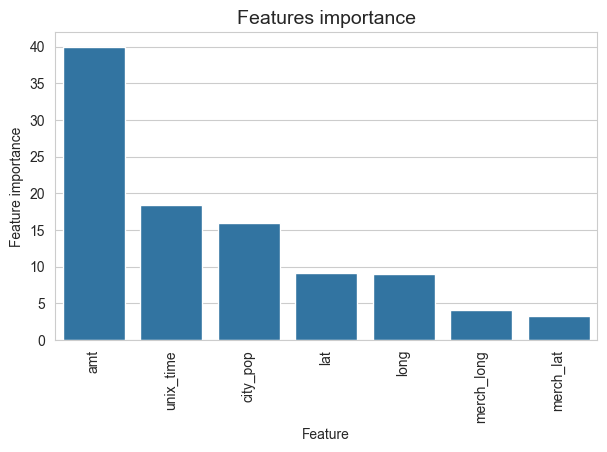

In [53]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()  

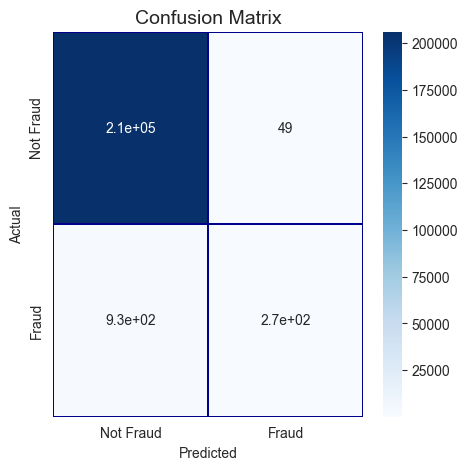

In [54]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [55]:
roc_auc_score(valid_df[target].values, preds)

0.6131592279067315

In [56]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [57]:
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:727: FutureWarning:

Pass `evals` as keyword args.

C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning:

[19:07:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.




[0]	train-auc:0.85870	valid-auc:0.85555
[50]	train-auc:0.93257	valid-auc:0.93142
[100]	train-auc:0.93544	valid-auc:0.93272
[150]	train-auc:0.95125	valid-auc:0.94978
[200]	train-auc:0.95734	valid-auc:0.95372
[250]	train-auc:0.96012	valid-auc:0.95618
[300]	train-auc:0.96207	valid-auc:0.95792
[350]	train-auc:0.96255	valid-auc:0.95831
[400]	train-auc:0.96335	valid-auc:0.95884
[450]	train-auc:0.96412	valid-auc:0.95936
[500]	train-auc:0.96453	valid-auc:0.95957
[550]	train-auc:0.96505	valid-auc:0.95989
[600]	train-auc:0.96560	valid-auc:0.96036
[650]	train-auc:0.96598	valid-auc:0.96062
[700]	train-auc:0.96626	valid-auc:0.96087
[750]	train-auc:0.96652	valid-auc:0.96107
[800]	train-auc:0.96690	valid-auc:0.96130
[850]	train-auc:0.96722	valid-auc:0.96155
[900]	train-auc:0.96748	valid-auc:0.96173
[950]	train-auc:0.96780	valid-auc:0.96195
[999]	train-auc:0.96801	valid-auc:0.96207


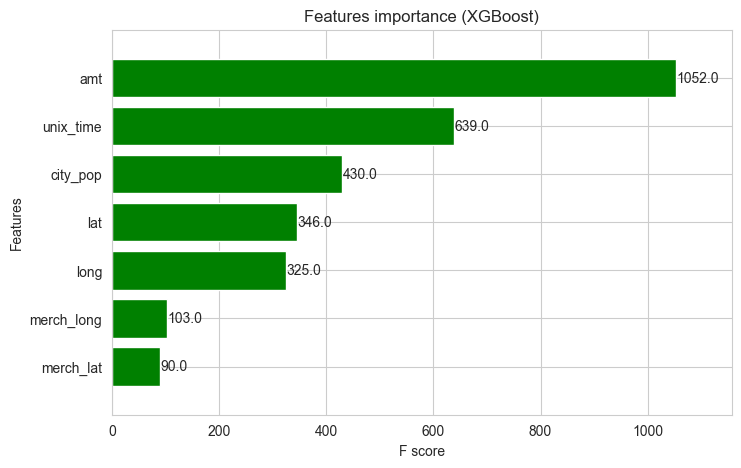

In [58]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

In [59]:
preds = model.predict(dtest)

In [60]:
roc_auc_score(test_df[target].values, preds)

0.9623350014110655

In [62]:
import pandas as pd

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

import pickle

import warnings 
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)

In [63]:
df_train = pd.read_csv(r"C:\Users\Acer\Downloads\anoly\2\archive (4)\fraudTrain.csv", low_memory=False, index_col=0)
df_test = pd.read_csv(r"C:\Users\Acer\Downloads\anoly\2\archive (4)\fraudTest.csv", low_memory=False, index_col=0)

In [64]:
df_train.shape, df_test.shape

((1296675, 22), (555719, 22))

In [65]:
list(df_train.columns) == list(df_test.columns)

True

In [66]:
df = pd.concat([df_train, df_test],ignore_index=True)

In [67]:
df.shape

(1852394, 22)

In [68]:
df.is_fraud.value_counts()

is_fraud
0    1842743
1       9651
Name: count, dtype: int64

In [69]:
def clean_df(df):
    return df.drop(['cc_num','first', 'last', 'street', 'city', 'state', 'zip', 'dob', 'trans_num','trans_date_trans_time'],axis=1)

df = clean_df(df)

In [70]:
df.head(2)

,merchant,category,amt,gender,lat,long,city_pop,job,unix_time,merch_lat,merch_long,is_fraud
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,36.0788,-81.1781,3495,"Psychologist, counselling",1325376018,36.011293,-82.048315,0
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,Special educational needs teacher,1325376044,49.159047,-118.186462,0


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 12 columns):
 #   Column      Dtype  
---  ------      -----  
 0   merchant    object 
 1   category    object 
 2   amt         float64
 3   gender      object 
 4   lat         float64
 5   long        float64
 6   city_pop    int64  
 7   job         object 
 8   unix_time   int64  
 9   merch_lat   float64
 10  merch_long  float64
 11  is_fraud    int64  
dtypes: float64(5), int64(3), object(4)
memory usage: 169.6+ MB


In [72]:
train, test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
train.shape, test.shape

((1481915, 12), (370479, 12))

In [73]:
def encode(df):
    df_obj = df.select_dtypes(include=['object'])
    encoders = {}
    for col in df_obj.columns:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
        encoders[col] = encoder
    with open('LE_mdl_v1.pkl', 'wb') as f:
        pickle.dump(encoders, f)
    return df

train = encode(train)

In [74]:
train.head(2)

,merchant,category,amt,gender,lat,long,city_pop,job,unix_time,merch_lat,merch_long,is_fraud
0,29,4,166.80,1,39.3426,-114.8859,450,254,1371108903,40.088507,-113.895268,0
1,536,11,28.86,0,34.3795,-118.5230,34882,219,1347476946,35.356925,-119.348148,0


In [75]:
x = train.drop(columns=['is_fraud'])
y = train['is_fraud']

In [76]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)

In [77]:
model1 = LogisticRegression()
model2 = RandomForestClassifier()
model3 = DecisionTreeClassifier()
model4 = xgb.XGBClassifier()

In [78]:
def model_train(model, x_train, y_train, x_test, y_test):
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    print('Accuracy Score: ',accuracy_score(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    with open(str(model)[:3] + '_mdl.pkl', 'wb') as f:
        pickle.dump(model,f)

In [79]:
model_train(model1, x_train, y_train, x_val, y_val)

Accuracy Score:  0.9941629580643964
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    294805
           1       0.00      0.00      0.00      1578

    accuracy                           0.99    296383
   macro avg       0.50      0.50      0.50    296383
weighted avg       0.99      0.99      0.99    296383



In [80]:
model_train(model3, x_train, y_train, x_val, y_val)

Accuracy Score:  0.9960254130635023
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    294805
           1       0.62      0.66      0.64      1578

    accuracy                           1.00    296383
   macro avg       0.81      0.83      0.82    296383
weighted avg       1.00      1.00      1.00    296383



In [81]:
model_train(model4, x_train, y_train, x_val, y_val)

Accuracy Score:  0.9977427855173879
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    294805
           1       0.88      0.67      0.76      1578

    accuracy                           1.00    296383
   macro avg       0.94      0.83      0.88    296383
weighted avg       1.00      1.00      1.00    296383

